
# Correlation Strategy Part I

  _This Jupyter Notebook belongs to the ...article..., part ..._
  
  In the experimental setup presented in the article MatTek dishes (R) where used to automatically correlate cells from light microscopy (LM) with electron microscopy (EM). 
  The common landmarks used between LM and EM, where the grid corners, as shown in the figure here:
<img src="images/mat_1.png" width="800"/>


 This correlation strategy, although very simple conceptually, in practice needs several refinements to achieve a good accuracy.
In this notebook, the MSE (mean square error) is taken as a measure of accuracy, first between estimated positions of landmarks and detected landmarks, and later on, in the second part, between targets (cells), and the ground truth position of the cell in the FIB/SEM microscope, as defined by the CLEM microscopist.
 
 
 ## 1. Building a simple linear model
 
 We start by the most simple approach: since we are in grid, we obtain 3 points of the grid to create an orthogonal base, so it can be used as reference. With this simple base, and based on the manufacturer specification of the grid (distance between squares), it is possible to compute a linear model to predict other positions in the same grid.
 
 <img src="images/model_1.png" width="400"/>
 
 This model is very simple. The 3 ideal $x$ grid points could be something like (0,0), (10,0) and (0,10), assuming the grid has a space of 10 units. The user of the microscope can identify $\hat x$ spots manually clicking on their positions. In CLEMSite it also possible to click in the center of a visible square grid and the 4 corners of the square will be computed automatically. 
 
 
 If the second option is chosen, then the four corners are automatically identified and the values saved in a folder.  We can find and load the four spot positions saved in the p0_* folder inside the SCAN folder of a CLEMSite project that used by the Navigator. 

In [1]:
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>


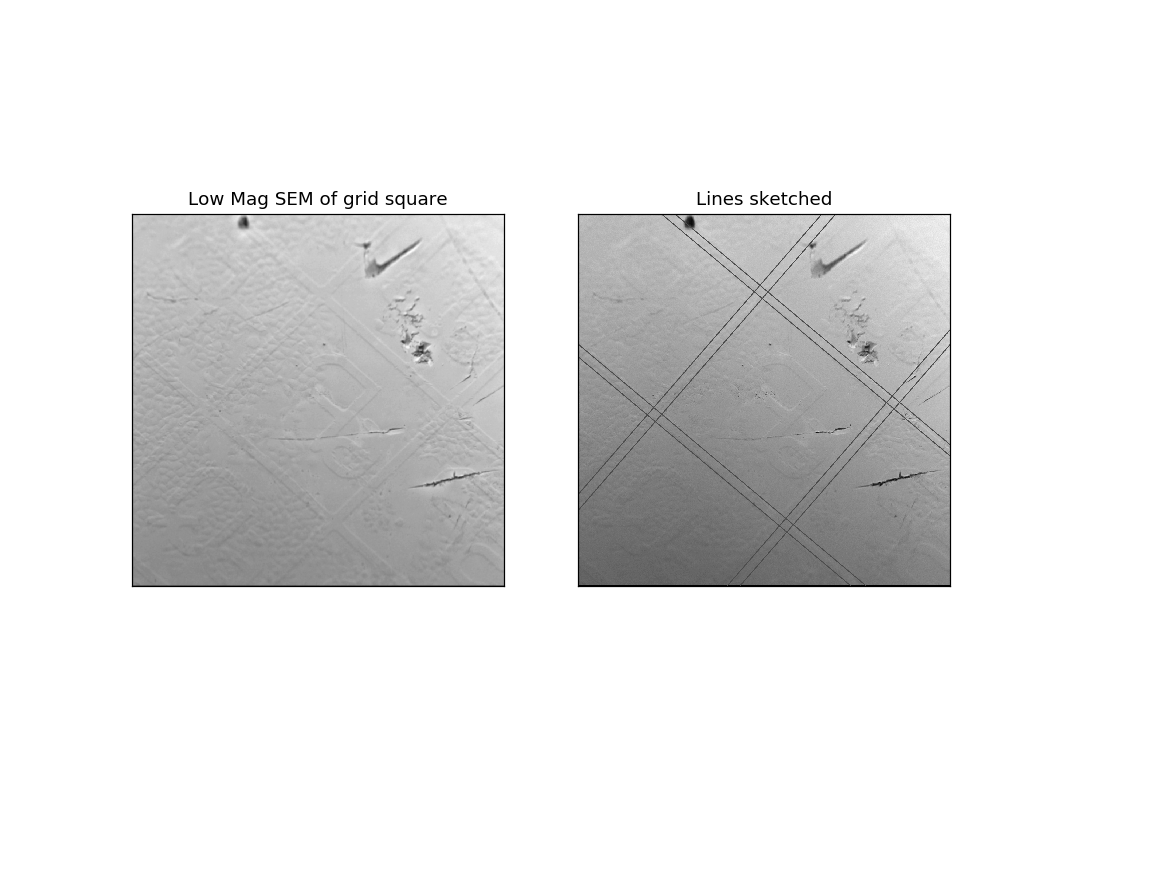

In [2]:
%matplotlib notebook

import os
from os import path
import glob,csv,re
import sys
import cv2
import numpy as np
import utilities 

# 13_Nov_18
SCAN_13 = ".\\13Jul18_1\\SCAN"
SCAN_13_p0 =  SCAN_13+"\\p0_20181031_164346"
lines =  SCAN_13_p0+"\\ld_31-Oct-2018-1643\lines_sketch.tif".replace("\\","/")
capture =  SCAN_13_p0+"\ld_31-Oct-2018-1643\prepro_p0_20181031_164346.tif".replace("\\","/")

im_capture = cv2.imread(capture,0)
im_lines_sketch = cv2.imread(lines,0)


utilities.show_images([im_capture,im_lines_sketch],titles= ["Low Mag SEM of grid square","Lines sketched"], shrink = 0.75)

The original detection of lines is approximate, so the grid crossing positions are not accurate. That is why an extra step refines each squared position with a bigger magnification (350 um FOV), using the algorithm from notebooks 1 and 2:

<IPython.core.display.Javascript object>


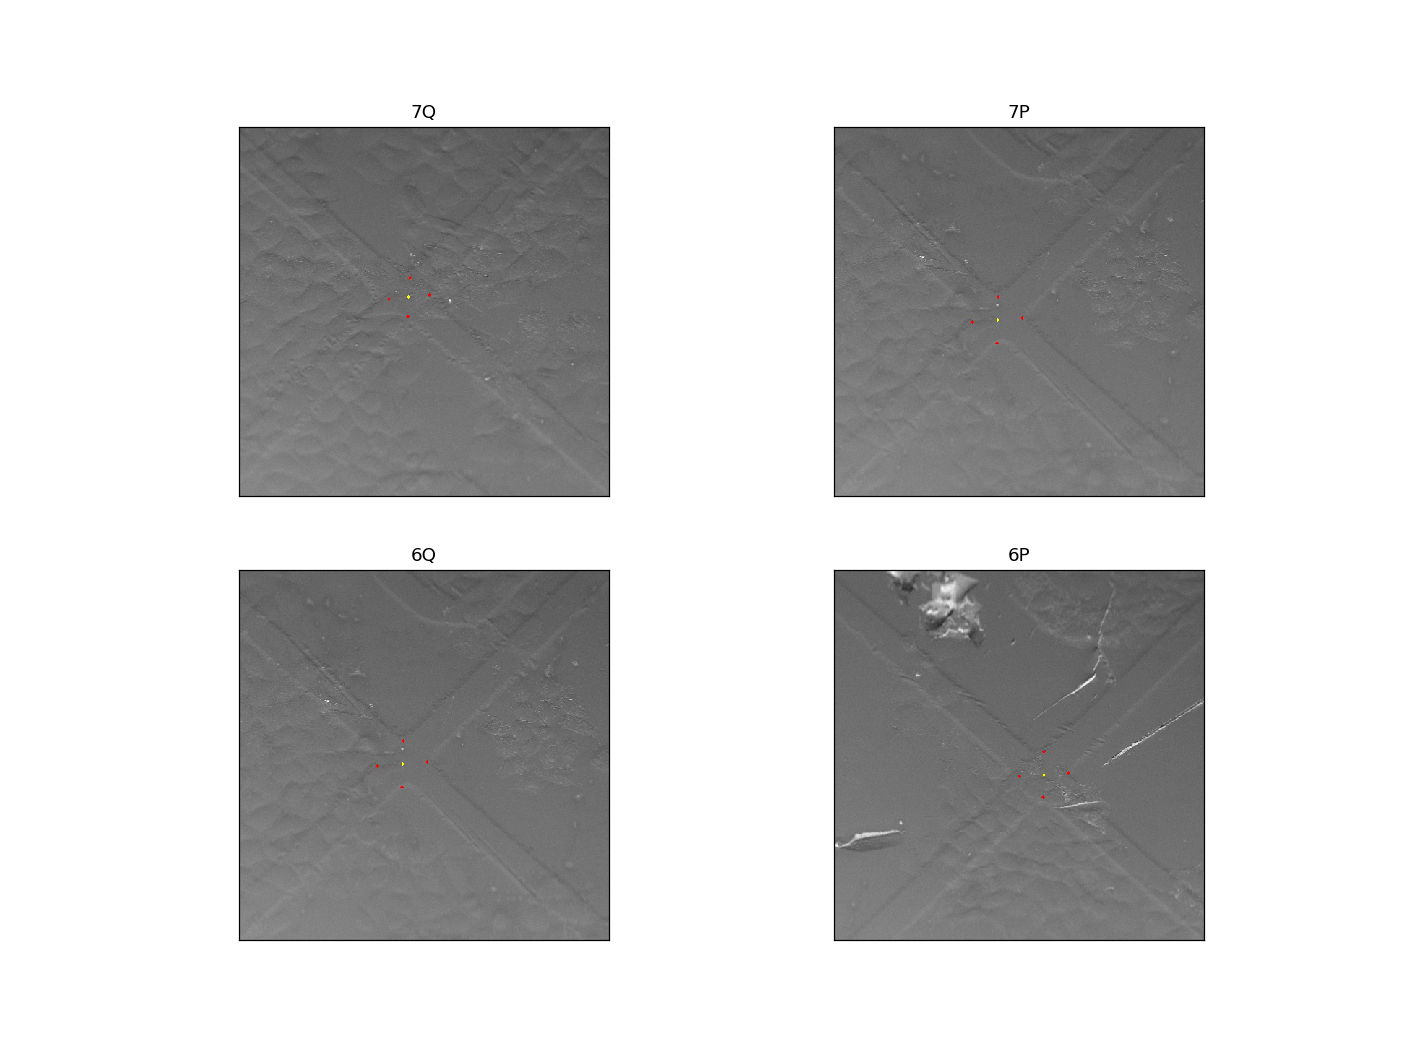

In [3]:
im0_f = SCAN_13_p0+"\\cross_det_ref_ref_0_7Q_201810311644344695\\ref_0_7Q_sketch.jpg"
im1_f = SCAN_13_p0+"\\cross_det_ref_ref_1_7P_201810311645323827\\ref_1_7P_sketch.jpg"
im2_f = SCAN_13_p0+"\\cross_det_ref_ref_2_6Q_201810311646300924\\ref_2_6Q_sketch.jpg"
im3_f = SCAN_13_p0+"\\cross_det_ref_ref_3_6P_201810311647288084\\ref_3_6P_sketch.jpg"

im0 = cv2.imread(im0_f,-1)
im1 = cv2.imread(im1_f,-1)
im2 = cv2.imread(im2_f,-1)
im3 = cv2.imread(im3_f,-1)
im0 = cv2.cvtColor(im0, cv2.COLOR_BGR2RGB)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2RGB)


utilities.show_images([im0,im2,im2,im3],cols =2,titles= ["7Q","7P","6Q","6P"],shrink = 0.5)

Each position is calculated in image coordinates and then translated to microscope stage coordinates. The values are stored in the files determined by an alphanumerical character followed by "_info.txt_" (e.g. 6P_info.txt). We can read those files as json:

In [4]:
import pandas as pd
import json

def readAllInfos(info_folder):
    data_positions = []
    list_files = glob.glob(info_folder+'\\??_info.txt')
    for el in list_files:
        #print(el)
        with open(el) as f:
            data_position = json.load(f)
            data_positions.append(data_position)
    df = pd.DataFrame(data_positions).T
    return df

df = readAllInfos(SCAN_13_p0)
df = df.transpose()

In [5]:
import csv
# The microscope stage coordinates have to be read from the individual folders inside the main folder and 
# replaced in Position X and Position Y (which are now the current center of the image)
for npath in glob.glob(os.path.join(SCAN_13_p0,'cross_det*')):
    file_p = glob.glob(os.path.join(npath,'ref_*_fpoints.csv'))[0]
    with open(file_p, newline='') as csvfile:
        valreader = csv.reader(csvfile, delimiter=',')
        for row in valreader:
            df.loc[df.tag==row[3],'posx'] = -float(row[0])
            df.loc[df.tag==row[3],'posy'] = -float(row[1])

            
df

DwellTime    FOV_X    FOV_Y PixelSize     WD PositionX PositionY PositionZ  \
0      8000  410.255  410.255   0.80128  0.005  -36275.4  -63334.9   41919.4   
1      8000  410.255  410.255   0.80128  0.005  -36629.3  -63741.6   41919.4   
2      8000  410.255  410.255   0.80128  0.005  -36712.9  -62967.6   41919.4   
3      8000  410.255  410.255   0.80128  0.005  -37066.9  -63374.4   41919.4   

  Width Height Beam              Aperture Detector Contrast Brightness  \
0   512    512  SEM  1,5 kV | 700 pA [An]     SESI  19.7648    50.4219   
1   512    512  SEM  1,5 kV | 700 pA [An]     SESI  19.7648    50.4219   
2   512    512  SEM  1,5 kV | 700 pA [An]     SESI  19.7648    50.4219   
3   512    512  SEM  1,5 kV | 700 pA [An]     SESI  19.7648    50.4219   

      posx     posy orientation tag letter_center  
0  36248.1  63356.5              6P                
1  36653.4  63751.3              6Q                
2  36686.4  62971.6              7P                
3  37084.5  63358.3              7Q


By visual inspection we can confirm that the yellow points, identified by our machine learning detector, are the crossing points. In our previous Jupyter notebook _"\\Development\\DLTrainingProjects\\crossing_Detector_SEM_MatTek\\CROSS_DETECTOR-UNET-part_II-test.ipynb"_ it was determined that the error of the algorithm in detection is $4.15+/-4\mu m$. To validate that the assumption holds, we double checked using Fiji to find the center of the coordinates manually and calculated the squared distance error in pixels:  

<table>
  <tr>
    <th>Naming</th>
    <th>Position X,Y</th>
    <th>Position X,Y Human</th>
    <th>Difference pixels</th>
    <th>Difference micrometers</th>
  </tr>
  <tr>
    <td>7Q</td>
    <td>(232,236)</td>
    <td>(234,236)</td>
    <td>2</td>
    <td>1.6</td>
  </tr>
  <tr>
    <td>7P</td>
    <td>(289,261)</td>
    <td>(287,259)</td>
    <td>2.83</td>
    <td>2.26</td>
  </tr>
  <tr>
    <td>6P</td>
    <td>(290,283)</td>
    <td>(286,284)</td>
    <td>4.12</td>
    <td>3.3</td>
  </tr>
  <tr>
    <td>6Q</td>
    <td>(226,268)</td>
    <td>(229,263)</td>
    <td>5.83</td>
    <td>4.67</td>
  </tr>
</table>

The average error for the four corners detected is 2.96 +/- 1.16 micrometers. We can assume this error in the expected range and continue with the values taken automatically to build our linear model of the grid using least squares.

After computing the image coordinates of the center, we translate those coordinates to stage coordinates. To satify the equation of least squares, we use two equivalent homogeneous spaces of coordinates: one were each landmark is separated 10 units and the real one. The class Map reads the MatTek grid specifications from the preferences file of CLEMSite, like:
 $ DIST_SQ = 560 # um $
 $ DIST_SPACE = 20 # um $
 $ DIST_GRID = 600 # 560+20+20 um $

['6P', '6Q', '7P', '7Q']


<IPython.core.display.Javascript object>


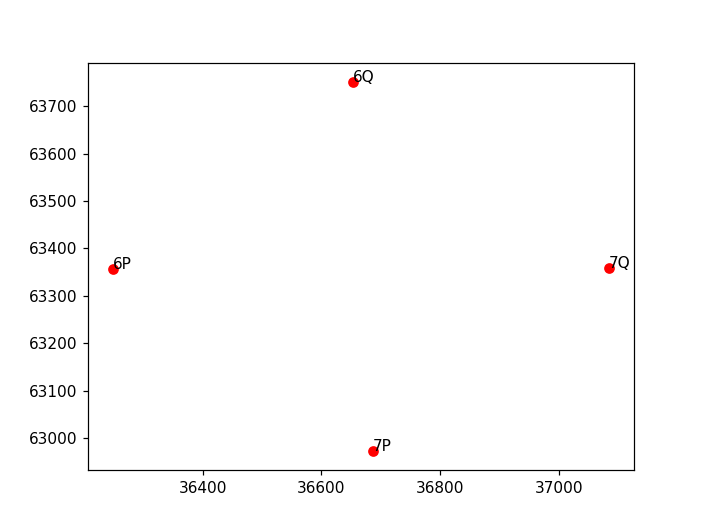

In [6]:
from matplotlib import pyplot as plt

df = df.transpose()
fpoints = np.array([[df[0].posx,df[0].posy],[df[1].posx,df[1].posy],[df[2].posx,df[2].posy],[df[3].posx,df[3].posy]], dtype = np.float32)
tags = [df[0].tag,df[1].tag,df[2].tag,df[3].tag]
print(tags)

fig, ax = plt.subplots()
ax.scatter(fpoints[:,0], fpoints[:,1], color='red')

for i, txt in enumerate(tags):
    ax.annotate(txt, (fpoints[i,0], fpoints[i,1]))

We are still missing parameter to complete our linear model: the orientation of the grid. This parameter is given by the user (using as simple control that makes the letter straight to the view, then the angle is inferred internally). We know the orientation of this example is 43 degrees. With 4 points, their respective names and angle, the Map class will generate an inner map by simply adding coordinates in the X and Y direction.

_NOTE: The next functions can be found in the files "occupancy_map.py" and "ptp.py" and are the same used in the software CLEMSite. To avoid problems with dependencies they have been copied to this notebook_


In [7]:
install_dir = "..\\..\\..\\"
sys.path.append( path.dirname( install_dir+"\\CLEMSite\\"))
from common.occupancy_map import *
my_map = Map(1)
my_map.generateGridMapCoordinates(-fpoints*0.001, tags, 43, type='EM')

<IPython.core.display.Javascript object>


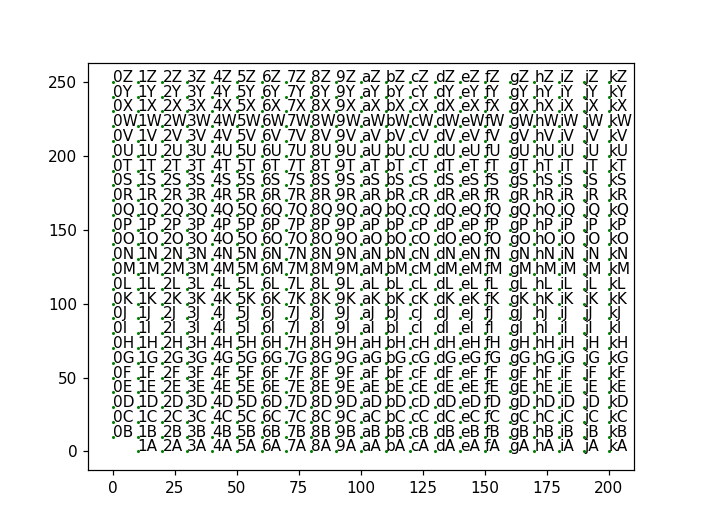

In [8]:
# let's plot the IDEAL squared map first
val_coords = np.array(list(my_map.map_coordinates_origin.values()))

fig, ax = plt.subplots()
ax.scatter(val_coords[:,0], val_coords[:,1], color='green',s=1)

for label,coord in my_map.map_coordinates_origin.items():
    ax.annotate(label, (coord[0], coord[1]))

<IPython.core.display.Javascript object>


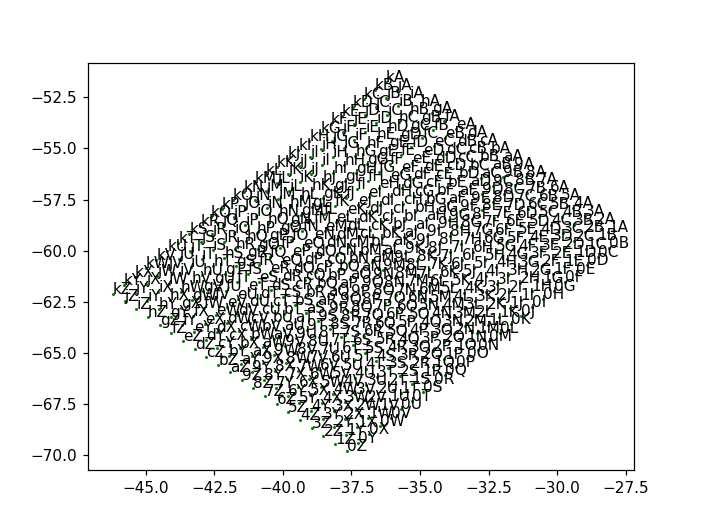

In [9]:
# let's plot such a map, now in microscope coordinates, rotated appropiately:
dest_coords = np.array(list(my_map.map_coordinates_destiny.values()))

fig, ax = plt.subplots()
ax.scatter(dest_coords[:,0], dest_coords[:,1], color='green',s=1)

for label,coord in my_map.map_coordinates_destiny.items():
    ax.annotate(label, (coord[0], coord[1]))

In [10]:
# Lets check for one random tag:
my_map.get4Neighbors('6O')

(['6O', '6N', '6P', '7O', '5O'],
 array([[ 60., 140.,   0.],
        [ 60., 130.,   0.],
        [ 60., 150.,   0.],
        [ 70., 140.,   0.],
        [ 50., 140.,   0.]], dtype=float32),
 array([[-35.850285, -62.94276 ,   0.      ],
        [-35.452457, -62.529007,   0.      ],
        [-36.24811 , -63.356518,   0.      ],
        [-36.2769  , -62.55693 ,   0.      ],
        [-35.423668, -63.328598,   0.      ]], dtype=float32))

In CLEMSite, once the 4 points are collected and the map is created, we are ready to do a SCAN procedure. The scan will sample the square positions one by one. In summary, the first steps done by CLEMSite to generate a global map of the grid is as it follows :

 <img src="images/scan.png" width="600"/>
 
 - Generate a list of estimated stage coordinates close to the origin (the first square taken as reference for the model)
 - Move to the first position in the list
 - Use the GLD (generalized line detector) to find the center of the image and compute the real stage coordinates from it
 - Replace the stage coordinates in the original map and mark them as "good"
 - Repeat until the list is completed.
 
Sampling the full grid (546 points) seems unnecessary. Usually around 80-100 positions are enough to have our first approach to map the sample. In addition, during the scan damaged or border crossings will be detected and marked as problematic in the map to avoid doing line detection on them in later transformations. 

Now, let's read the results of one of these scans:

In [11]:
# Read all info values
ra = readAllInfos(SCAN_13)
ra = ra.transpose()
for npath in glob.glob(os.path.join(SCAN_13,'cross_det*')):
    file_p = glob.glob(os.path.join(npath,'ref_*_fpoints.csv'))[0]
    with open(file_p, newline='') as csvfile:
        valreader = csv.reader(csvfile, delimiter=',')
        for row in valreader:
            ra.loc[ra.tag==row[3],'posx'] = float(row[0])
            ra.loc[ra.tag==row[3],'posy'] = float(row[1])

ra.head(10)

DwellTime    FOV_X    FOV_Y PixelSize          WD PositionX PositionY  \
0      4000  307.154  307.154  0.599911  0.00538259  -30487.7  -61032.3   
1      4000  307.154  307.154  0.599911  0.00535986  -31692.2    -62204   
2      4000  307.154  307.154  0.599911  0.00535986  -32090.2  -62593.7   
3      4000  307.154  307.154  0.599911  0.00538259  -31728.8    -61422   
4      4000  307.154  307.154  0.599911  0.00486042  -34546.1  -64141.8   
5      4000  307.154  307.154  0.599911  0.00486042  -35340.6  -64914.2   
6      4000  307.154  307.154  0.599911  0.00486042  -35740.8  -65299.7   
7      4000  307.154  307.154  0.599911  0.00535986  -32164.4  -61030.5   
8      4000  307.154  307.154  0.599911  0.00535986  -32562.4  -61420.2   
9      4000  307.154  307.154  0.599911  0.00520918    -32958  -61809.7   

  PositionZ Width Height Beam              Aperture Detector Contrast  \
0   41919.4   512    512  SEM  1,5 kV | 700 pA [An]     SESI  19.7648   
1   41919.4   512    512  SEM  1,5 kV | 700 pA [An]     SESI  19.7648   
2   41919.4   512    512  SEM  1,5 kV | 700 pA [An]     SESI  19.7648   
3   41919.4   512    512  SEM  1,5 kV | 700 pA [An]     SESI  19.7648   
4   41919.4   512    512  SEM  1,5 kV | 700 pA [An]     SESI  19.7648   
5   41919.4   512    512  SEM  1,5 kV | 700 pA [An]     SESI  19.7648   
6   41919.4   512    512  SEM  1,5 kV | 700 pA [An]     SESI  19.7648   
7   41919.4   512    512  SEM  1,5 kV | 700 pA [An]     SESI  19.7648   
8   41919.4   512    512  SEM  1,5 kV | 700 pA [An]     SESI  19.7648   
9   41919.4   512    512  SEM  1,5 kV | 700 pA [An]     SESI  19.7648   

  Brightness     posx     posy orientation tag letter_center  
0    50.4219 -30497.9 -61019.7              2F                
1    50.4219 -31698.2   -62195              2I                
2    50.4219   -32095 -62587.1              2J                
3    50.4219 -31733.6 -61417.8              3H                
4    50.4219 -34531.7 -64131.6              3O                
5    50.4219 -35341.8 -64911.8              3Q                
6    50.4219 -35744.4 -65299.7              3R                
7    50.4219 -32167.4 -61031.7              4H                
8    50.4219 -32570.2   -61425              4I                
9    50.4219 -32968.2 -61806.7              4J

In [12]:
# Let's compute how big is the area we are exploring
max_d_x = np.round(np.max(ra.posx)-np.min(ra.posx),2)*0.001
max_d_y = np.round(np.max(ra.posy)-np.min(ra.posy),2)*0.001
print("Maximum distance in x between points:"+str(np.round(max_d_x,3))+" mm.")
print("Maximum distance in y between points:"+str(np.round(max_d_y,3))+" mm.")
print("Area covered by the scan:"+str(np.round(max_d_x*max_d_y,3))+" mm2")

Maximum distance in x between points:8.291 mm.
Maximum distance in y between points:7.783 mm.
Area covered by the scan:64.532 mm2


We also calculated the area covered by the 53 points of this scan. It also can vary between scans, always between 50 and 100 $mm^2$. Potentially, the full dish could be scanned (1 $cm^2$).


And now, let's observe the difference between computed and "real" positions :

<IPython.core.display.Javascript object>


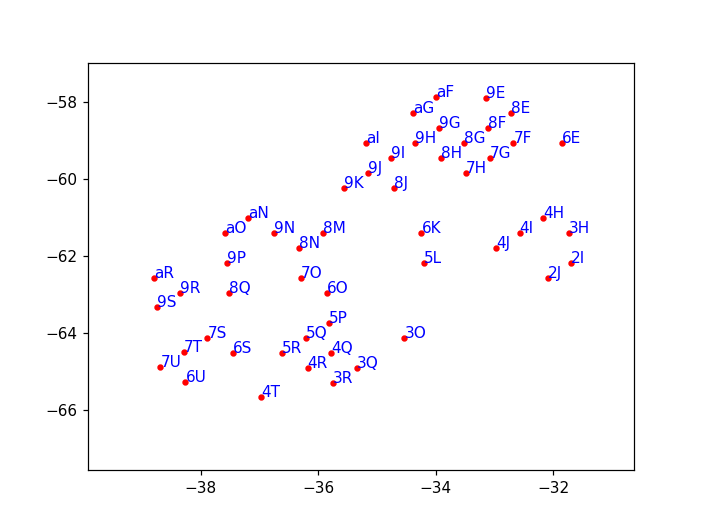

In [50]:
# let's plot such a map, now in microscope coordinates:
dest_coords = np.array(list(my_map.map_coordinates_destiny.values()))
found_coords = np.array([el for el in zip(ra.posx,ra.posy)])*0.001
found_tags = ra.tag

fig, ax = plt.subplots()
ax.scatter(dest_coords[:,0], dest_coords[:,1], color='green',s=5)
ax.scatter(found_coords[:,0], found_coords[:,1], color='red',s=10)

for label,coord in my_map.map_coordinates_destiny.items():
    ax.annotate(label, (coord[0], coord[1]))

for i,fcoord in enumerate(found_coords):
    ax.annotate(found_tags[i], (fcoord[0], fcoord[1]), color='blue',annotation_clip=True)

In [14]:
dict_error = {}
found_tags = list(ra.tag)
for label,coord in my_map.map_coordinates_destiny.items():
    if label in found_tags:
        i = found_tags.index(label)
        dict_error[i]  = ((coord[0]-found_coords[i][0])**2 + (coord[1]-found_coords[i][1])**2)*1000

mse = np.mean(list(dict_error.values()))
rmsd = np.sqrt(mse)
rmsd_sd = np.std(list(dict_error.values()))
print("Total RMSD:"+str(rmsd)+"+/- 2STD "+str(rmsd_sd))

Total RMSD:4.751039675510408+/- 2STD 21.37397223234978


The root of the mean square error in micrometers is good but it has a big standard deviation: 21 micrometers!!

In [15]:
my_map.calculated_distgrid

array([[0.56574189],
       [0.58332327]])

It is very interesting to observe that the square we had measured is not a square... It has 566 by 583 microns. The positions are taken from images with a field of view of 350 micrometers and totally independent. This could be due camera distortions or we have to assume that the reason is the presence of tilting in the sample (maybe by mounting the resin is not flattened enough at the bottom). The expected result was 580 micrometers ( with the sequence 20-crossing-20-560-20-crossing-20, which should give the 600 um from the manufacturer).

In [16]:
from scipy.spatial import distance
all_distances_bwen_points = distance.pdist([ coord for coord in zip(ra.posx,ra.posy)])
ald = all_distances_bwen_points[all_distances_bwen_points<650]
import plotly.express as px
fig = px.histogram(ald, nbins = 40)
fig.show()

In the following contour plot, we can observe that data drops with the distance where the positions where gathered, which confirms the suspicions of a tilting.

In [17]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(go.Contour(
        x = found_coords[:,0],
        y = found_coords[:,1],
        z = list(dict_error.values()),
               colorbar=dict(nticks=10, ticks='outside',
                         ticklen=5, tickwidth=1,
                         showticklabels=True,
                         tickangle=0, tickfont_size=12),
    contours=dict(
            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 12,
                color = 'white',
            ))))

fig.show()

What would be the error if compute an affine transformation using all the positions we found in the scan instead of the old linear map? Let's calculate the RMSD associated to a global transformation. But before, we will introduce the concept that CLEMSite uses for mapping.

## The VirtualGrid Map class in CLEMSite 

Internally, CLEMSite cannot be a simple affine transformation. It uses a system of maps to correlate positions and also each position is in the map is qualified according to a status. Let's look at the Grid Map class.


In [35]:
from common.virtualGridMap import *
from common.virtualMapManager import *
from common.microadapterAtlas import *
from numpy.linalg import matrix_rank,qr
from scipy.linalg import orth
import logging
import re
import os
import glob,csv


In [36]:
logger = logging.getLogger('MyLogger')
logger.setLevel(logging.DEBUG)
ch = logging.StreamHandler(sys.stdout)
dformat = logging.Formatter("%(asctime)s - %(message)s")
ch.setFormatter(dformat)
logger.addHandler(ch)
# Server that connects to CLEMSiteServer. We don't need it but it is required
# by the VirtualMapManagerSEM class
msc_server = MicroAdapterAtlas()  

msc_server.setLogger(logger)
vMapManager = VirtualMapManagerSEM(logger, msc_server)

# We add a canvas-SEM map type. This will create an inner virtual Grid Map
vMapManager.addMap("Canvas_SEM")

To use the class Virtual Grid Map we need understand the system of mapping from CLEMSite. 
Three types of maps can exist inside the VirtualMapManager :
- Canvas-LM, for creating a map based on positions of the light microscope.
- Canvas-SEM, ideal grid versus real SEM positions of landmarks. 
- LM-SEM, correspondences of stage coordinates from LM and SEM. 

<img src="images/maps.png" width="800"/>

For the SEM microscope only the Canvas-SEM and LM-SEM maps are needed.



Points, inside the VirtualMap class, are catalogued in 4 types:

<table>
  <tr>
    <th>Type of Position</th>
    <th>Origin Map</th>
    <th>Destiny Map</th>
    <th style="text-align:left">Description</th>
  </tr>
  <tr>
    <td style="text-align:left">CALIBRATED (Scanned Landmark)</td>
    <td style="width:100px">Value defined</td>
    <td style="width:100px">Value defined</td>
    <td style="text-align:left">Position that can be recognised in both maps and used as reference, e.g., LM crossing coordinates in LM and SEM.</td>
  </tr>
   <tr>
    <td style="text-align:left">NON_CALIBRATED (Non Scanned Landmark)</td>
    <td>Value defined</td>
    <td>Not available</td>
    <td style="text-align:left">Position that has not been found yet in the destiny map, e.g. the LM coordinates are available but not the SEM</td>
  </tr>
   <tr>
    <td style="text-align:left">ACQUIRED</td>
    <td>Not Available</td>
    <td>Value defined</td>
    <td style="text-align:left">Position that has no correspondence in the origin map. E.g. Moving around in SEM we managed to distinguish a cell position, so we decided to save it.</td>
    </tr>
    <tr>
    <td style="text-align:left">TARGET (Organelle position)</td>
    <td>Value defined</td>
    <td>Not available</td>
    <td style="text-align:left">Position that has no correspondence in the destiny map, it has to be predicted. E.g. the centroid of the cell we are searching in LM.</td>
    </tr>
</table>
    
   In addition to that, the point can be in a state blocked or unblocked. It is blocked if it is outside limits or from a damaged region, or if we do not want to use that point as reference for a local affine transformation between LM and SEM.
  The following picture shows a summary of how this is depicted in the CLEMSite app:
  <img src="images/mappingCLEMSite.PNG" width="800"/>

To compute our global transformation, after creating the map, we can add the set of points we obtained before:

In [37]:
# Now add the points, 
vMapManager.addSetPoints(origin_coords_Canvas, destiny_coords_SEM, found_tags, "Canvas_SEM",PointType.calibrated,updateModel=True)

2020-07-10 22:42:46,218 - From Canvas_SEM:Updating transform with 53 reference points


To compute a global transformation (with all 53 points) and evaluate its error, we call the function updateErrorByCV, which does the following:
   - Get one position, and take 50 neighbors (we know our dataset has 53 points, so good enough).
   - Compute an affine transformation with those 50 closest neighbors and predict the position of itself.
   - Compute the RMSD between the predicted and the real position of the excluded point.
   - If the error distance between predicted and real is bigger than the tolerance (30 $\mu m$ in this case), the point is put in a blocked list and removed from the dataset.
   - Repeat for the rest of the positions (52).
   - If a point has been quicked out, we repeat the procedure. By doing this we are computing more accurate transformations.
   - The procedure iterates until there is a convergence of the average error, i.e., no more points are quicked out.
  

In [48]:
# We discard any point that has an error bigger than 30 um.
blocked_list, blocked_errors, good_list,error_list = vMapManager.updateErrorByCV("Canvas_SEM", num_neighs = 50, tolerance = 30)

2020-07-10 23:10:42,799 - Finding bad apples in predictions!
2020-07-10 23:10:42,799 - # Iteration 0
2020-07-10 23:10:53,081 - #!!# BLOCKED: Position :2F with values [-30497.914 -61019.727      0.   ] has exceedeed minimum error. Error found to be: 69.27159118652344
2020-07-10 23:11:03,325 - Position :2I with values [-31698.207 -62194.965      0.   ]. Error found to be: 18.726789474487305
2020-07-10 23:11:04,134 - Position :2J with values [-32094.975 -62587.055      0.   ]. Error found to be: 4.564345836639404
2020-07-10 23:11:14,004 - Position :3H with values [-31733.568 -61417.773      0.   ]. Error found to be: 20.487472534179688
2020-07-10 23:11:18,525 - Position :3O with values [-34531.695 -64131.58       0.   ]. Error found to be: 11.636796951293945
2020-07-10 23:11:18,525 - # Iteration 5
2020-07-10 23:11:22,486 - Position :3Q with values [-35341.844 -64911.82       0.   ]. Error found to be: 8.724169731140137
2020-07-10 23:11:29,810 - Position :3R with values [-35744.36  -65299.

In practice we use a set of 20 neighbors, and the transformation is stored locally for the next step. As we see here, the accuracy is better with the closest 20 neighbors.

In [49]:
# We discard any point that has an error bigger than 30 um.
blocked_list, blocked_errors, good_list,error_list = vMapManager.updateErrorByCV("Canvas_SEM", num_neighs = 20, tolerance = 30)

2020-07-10 23:16:20,204 - Finding bad apples in predictions!
2020-07-10 23:16:20,205 - # Iteration 0
2020-07-10 23:16:20,225 - Position :2F with values [-30497.914 -61019.727      0.   ]. Error found to be: 5.7514729499816895
2020-07-10 23:16:20,246 - Position :2I with values [-31698.207 -62194.965      0.   ]. Error found to be: 1.7001523971557617
2020-07-10 23:16:20,268 - Position :2J with values [-32094.975 -62587.055      0.   ]. Error found to be: 5.098572254180908
2020-07-10 23:16:20,289 - Position :3H with values [-31733.568 -61417.773      0.   ]. Error found to be: 2.5421555042266846
2020-07-10 23:16:20,310 - Position :3O with values [-34531.695 -64131.58       0.   ]. Error found to be: 8.9122953414917
2020-07-10 23:16:20,310 - # Iteration 5
2020-07-10 23:16:20,342 - Position :3Q with values [-35341.844 -64911.82       0.   ]. Error found to be: 4.093669891357422
2020-07-10 23:16:21,857 - Position :3R with values [-35744.36  -65299.727      0.   ]. Error found to be: 9.138648

## Average error for 3 experiments

Here we will repeat the same strategy with 2 more SCANS (14 Nov. and 19 Nov.).

In [ ]:
def read_position_from_files(root_dir):
    # Read all info values
    dfn = readAllInfos(root_dir)
    dfn = dfn.transpose()
    for npath in glob.glob(os.path.join(root_dir,'cross_det*')):
        file_p = glob.glob(os.path.join(npath,'ref_*_fpoints.csv'))[0]
        with open(file_p, newline='') as csvfile:
            valreader = csv.reader(csvfile, delimiter=',')
            for row in valreader:
                dfn.loc[dfn.tag==row[3],'posx'] = float(row[0])
                dfn.loc[dfn.tag==row[3],'posy'] = float(row[1])
    return dfn

SCAN_14 = ".\\14Nov18\\SCAN"
SCAN_14_p0 = ".\\14Nov18\\SCAN\\p0_20190313_171704"

ra2_p0 = read_position_from_files(SCAN_14_p0)
fpoints = np.array([ np.array([el[0],el[1],0]) for el in zip(ra2_p0.posx,ra2_p0.posy)])
tags = list(ra2_p0.tag)
my_map_14N= Map(1)
my_map_14N.generateGridMapCoordinates(-fpoints*0.001, tags, 48, type='EM')

In [ ]:
ra2 = read_position_from_files(SCAN_14)
# let's plot such a map, now in microscope coordinates:
dest_coords = np.array(list(my_map.map_coordinates_destiny.values()))
found_coords = np.array([el for el in zip(-ra2.posx,-ra2.posy)])*0.001
found_tags = ra2.tag


# READ the 4 positions for the linear model
# and recreate the positions

fig, ax = plt.subplots()
ax.scatter(dest_coords[:,0], dest_coords[:,1], color='green',s=5)
ax.scatter(found_coords[:,0], found_coords[:,1], color='red',s=10)

for label,coord in my_map.map_coordinates_destiny.items():
    ax.annotate(label, (coord[0], coord[1]))

for i,fcoord in enumerate(found_coords):
    ax.annotate(found_tags[i], (fcoord[0], fcoord[1]), color='blue',annotation_clip=True)

In [ ]:
# Area covered
max_d_x = np.round(np.max(ra2.posx)-np.min(ra2.posx),2)*0.001
max_d_y = np.round(np.max(ra2.posy)-np.min(ra2.posy),2)*0.001
print("Maximum distance in x between points:"+str(np.round(max_d_x,3))+" mm.")
print("Maximum distance in y between points:"+str(np.round(max_d_y,3))+" mm.")
print("Area covered by the scan:"+str(np.round(max_d_x*max_d_y,3))+" mm2")

In [ ]:
# Error plot and average global error

In [ ]:
# Error from sampled plots

In [ ]:
SCAN_19_p0 = ".\\19Nov18\\SCAN\\p0_20190418_185429"
# Read all info values
ra3 = readAllInfos(SCAN_19)
ra3 = ra3.transpose()
for npath in glob.glob(os.path.join(SCAN_19,'cross_det*')):
    file_p = glob.glob(os.path.join(npath,'ref_*_fpoints.csv'))[0]
    with open(file_p, newline='') as csvfile:
        valreader = csv.reader(csvfile, delimiter=',')
        for row in valreader:
            ra3.loc[ra3.tag==row[3],'posx'] = float(row[0])
            ra3.loc[ra3.tag==row[3],'posy'] = float(row[1])

ra3.head()

Average of data: 
   
<table>
  <tr>
    <th>Sample</th>
    <th>Value</th>
  </tr>
  <tr>
    <td style="text-align:left">CALIBRATED (Scanned Landmark)</td>
    <td style="width:100px">Value defined</td>
  </tr>
    </table>

-- Explanation of how to operate in independent mode (no LM)